### Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter, ImageEnhance
import cv2
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical
from collections import Counter
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


### Load business.json file from yelp

In [26]:
def load_business_categories(business_path='yelp_academic_dataset_business.json'):
    """
    Load only business_id and categories from business.json file
    """
    business_data = []
    
    print(f"Loading business categories from {business_path}...")
    
    if os.path.exists(business_path):
        with open(business_path, 'r') as f:
            for line in f:
                business = json.loads(line)
                # Only extract business_id and categories
                business_data.append({
                    'business_id': business.get('business_id'),
                    'categories': business.get('categories')
                })
                
                # if len(business_data) % 5000 == 0:
                #     print(f"Loaded {len(business_data)} businesses...")
    
    return pd.DataFrame(business_data)

In [3]:
def preprocess_categories(business_df):
    """
    Preprocess categories into features for neural network input
    """
    features_df = business_df.copy()
    
    print("Preprocessing categories...")
    
    # Handle missing categories
    features_df['categories'] = features_df['categories'].fillna('')
    
    # Count number of categories per business
    features_df['num_categories'] = features_df['categories'].apply(
        lambda x: len([cat.strip() for cat in str(x).split(',') if cat.strip()]) if x else 0
    )
    
    # Get all unique categories across all businesses
    all_categories = []
    for cats in features_df['categories']:
        if cats:
            categories_list = [cat.strip() for cat in str(cats).split(',') if cat.strip()]
            all_categories.extend(categories_list)
    
    # Find top categories (limit to top 15 to keep feature count manageable)
    category_counts = Counter(all_categories)
    top_categories = [cat for cat, count in category_counts.most_common(15)]
    
    print(f"Top 15 categories found: {top_categories}")
    
    # Create binary features for top categories
    for cat in top_categories:
        # Clean category name for column naming
        clean_cat_name = cat.replace(" ", "_").replace("&", "and").replace("/", "_").replace("-", "_")
        column_name = f'category_{clean_cat_name}'
        
        features_df[column_name] = features_df['categories'].apply(
            lambda x: 1 if x and cat in str(x) else 0
        )
    
    # Select final feature columns (excluding original categories text)
    feature_columns = ['num_categories'] + [col for col in features_df.columns if col.startswith('category_')]
    
    # Create final feature matrix
    final_features = features_df[['business_id'] + feature_columns].copy()
    
    print(f"Created {len(feature_columns)} category features:")
    print(f"  - num_categories: count of categories per business")
    print(f"  - {len([col for col in feature_columns if col.startswith('category_')])} binary category indicators")
    
    return final_features, feature_columns

def create_labels_from_categories(photos_df, business_features_df):
    """
    Create labels based on dominant business categories
    This is a temporary solution - you should get proper labels from instructor
    """
    # Get category columns that exist in business_features_df
    category_cols = [col for col in business_features_df.columns if col.startswith('category_')]
    
    # Merge to get categories for each photo
    merge_cols = ['business_id'] + category_cols[:5]  # Take first 5 category columns
    photos_with_cats = photos_df.merge(
        business_features_df[merge_cols], 
        on='business_id', 
        how='left'
    )
    
    # Create labels based on dominant category
    def assign_label(row):
        # Check if any category columns exist and have values
        cat_values = [row.get(col, 0) for col in category_cols[:5] if col in row]
        
        if not cat_values or all(pd.isna(val) or val == 0 for val in cat_values):
            return 'other'
        
        # Simple rule-based assignment
        if any('restaurant' in col.lower() or 'food' in col.lower() for col in category_cols[:5] if row.get(col, 0) == 1):
            return 'food'
        elif any('shopping' in col.lower() or 'retail' in col.lower() for col in category_cols[:5] if row.get(col, 0) == 1):
            return 'shopping'
        elif any('nightlife' in col.lower() or 'bar' in col.lower() for col in category_cols[:5] if row.get(col, 0) == 1):
            return 'nightlife'
        elif any('beauty' in col.lower() or 'spa' in col.lower() for col in category_cols[:5] if row.get(col, 0) == 1):
            return 'beauty'
        else:
            return 'other'
    
    photos_with_cats['label'] = photos_with_cats.apply(assign_label, axis=1)
    return photos_with_cats['label'].values


### Load photos

In [4]:
def load_yelp_data(photos_path='photos.json', photos_dir='photos', limit=10000):
    """
    Load Yelp photos data from photos.json file
    """
    photos_data = []
    
    print(f"Loading photos data from {photos_path}...")
    
    # Load photos data (limit to 10,000 images)
    if os.path.exists(photos_path):
        with open(photos_path, 'r') as f:
            for i, line in enumerate(f):
                if i >= limit:
                    break
                photo = json.loads(line)
                
                # Check if corresponding image file exists
                photo_filename = f"{photo['photo_id']}.jpg"
                photo_path = os.path.join(photos_dir, photo_filename)
                
                if os.path.exists(photo_path):
                    photo['image_path'] = photo_path
                    photos_data.append(photo)
                    
                if len(photos_data) % 1000 == 0:
                    print(f"Loaded {len(photos_data)} photos with existing image files...")
    
    return pd.DataFrame(photos_data)

### Preprocessing Functions

In [24]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """
    Load and basic preprocessing of an image
    """
    try:
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            return img_array
        else:
            print(f"Image {img_path} does not exist, returning black image")
            return np.zeros((target_size[0], target_size[1], 3))
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return np.zeros((target_size[0], target_size[1], 3))

def apply_gaussian_blur(image, kernel_size=5):
    """
    Apply Gaussian blur to image
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def apply_histogram_equalization(image):
    """
    Apply histogram equalization to improve contrast
    """
    if len(image.shape) == 3:
        # Convert to YUV and equalize Y channel
        yuv = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2YUV)
        yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
        return cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    else:
        return cv2.equalizeHist(image.astype(np.uint8))

def apply_intensity_threshold(image, threshold=127):
    """
    Apply intensity thresholding
    """
    gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    return cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)

def resize_and_scale_images(df, target_size=(224, 224), sample_size=10000):
    """
    Resize and scale images from the real Yelp dataset
    """
    images = []
    labels = []
    valid_indices = []
    
    # print(f"Processing up to {sample_size} images from {len(df)} available photos...")
    
    for idx, row in df.iterrows():
        if len(images) >= sample_size:
            break
            
        img_path = row['image_path']
        
        if os.path.exists(img_path):
            img = load_and_preprocess_image(img_path, target_size)
            
            # Scale to [0, 1]
            img = img / 255.0
            
            images.append(img)
            labels.append(row['label'])
            valid_indices.append(idx)
            
            # if len(images) % 100 == 0:
            #     # print(f"Processed {len(images)} images...")
    
    print(f"Successfully processed {len(images)} images")
    return np.array(images), np.array(labels), valid_indices

def apply_advanced_preprocessing(images, apply_blur=True, apply_hist_eq=True, apply_threshold=False):
    """
    Apply advanced preprocessing techniques
    """
    processed_images = []
    
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)
        
        processed_img = img_uint8.copy()
        
        if apply_blur:
            processed_img = apply_gaussian_blur(processed_img, kernel_size=3)
        
        if apply_hist_eq:
            processed_img = apply_histogram_equalization(processed_img)
        
        if apply_threshold:
            processed_img = apply_intensity_threshold(processed_img, threshold=127)
        
        processed_img = processed_img.astype(np.float32) / 255.0
        processed_images.append(processed_img)
    
    return np.array(processed_images)

### Visualization Functions

In [6]:
def visualize_augmentation(generator, label_encoder, num_images=8):
    """
    Visualize augmented images
    """
    batch_x, batch_y = next(generator)
    
    print(f"Batch X shape: {batch_x.shape}")
    print(f"Batch Y shape: {batch_y.shape}")
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    for i in range(min(num_images, len(batch_x))):
        img = batch_x[i]
        
        if img.max() <= 1.0:
            if img.max() < 0.1:
                img = img / (img.max() + 1e-8)
            axes[i].imshow(img, vmin=0, vmax=1)
        else:
            axes[i].imshow(img.astype('uint8'))
            
        label_idx = np.argmax(batch_y[i])
        label_name = label_encoder.classes_[label_idx]
        axes[i].set_title(f'Label: {label_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Augmented Training Images', y=1.02, fontsize=16)
    plt.show()

def visualize_preprocessing_effects(original, blur, hist_eq, threshold, combined, idx=0):
    """
    Visualize the effects of different preprocessing techniques
    """
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    images = [original[idx], blur[idx], hist_eq[idx], threshold[idx], combined[idx]]
    titles = ['Original', 'Gaussian Blur', 'Histogram Eq.', 'Threshold', 'Combined']
    
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img)
        axes[i].set_title(title, fontsize=12)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Preprocessing Techniques Comparison', y=1.05, fontsize=16)
    plt.show()

def check_data_quality(X, y, dataset_name):
    """
    Perform data quality checks
    """
    print(f"\n{dataset_name} Quality Checks:")
    print(f"  Shape: {X.shape}")
    print(f"  Data type: {X.dtype}")
    print(f"  Min value: {X.min():.4f}")
    print(f"  Max value: {X.max():.4f}")
    print(f"  Mean: {X.mean():.4f}")
    print(f"  Std: {X.std():.4f}")
    print(f"  NaN values: {np.isnan(X).sum()}")
    print(f"  Labels shape: {y.shape}")
    print(f"  Label classes: {y.shape[1]}")

### Preprocessing

In [27]:
print("="*50)
print("ENHANCED PREPROCESSING WITH BUSINESS CATEGORIES")
print("="*50)

# Constants
TARGET_SIZE = (224, 224)  # Standard size for VGG and EfficientNet
BATCH_SIZE = 32

# 1. Load business categories
print("\n1. Loading business categories...")
business_df = load_business_categories('yelp_academic_dataset_business.json')
# print(f"Loaded {len(business_df)} businesses")
if len(business_df) > 0:
    sample_categories = business_df['categories'].dropna().head(3).tolist()
    print(f"Sample categories: {sample_categories}")

ENHANCED PREPROCESSING WITH BUSINESS CATEGORIES

1. Loading business categories...
Loading business categories from yelp_academic_dataset_business.json...
Sample categories: ['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists', 'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services', 'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores']


In [8]:
# 2. Preprocess categories into features
print("\n2. Preprocessing categories...")
business_features, category_feature_names = preprocess_categories(business_df)
print(f"Business features shape: {business_features.shape}")
print(f"Feature columns: {category_feature_names}")


2. Preprocessing categories...
Preprocessing categories...
Top 15 categories found: ['Restaurants', 'Food', 'Shopping', 'Home Services', 'Beauty & Spas', 'Nightlife', 'Health & Medical', 'Local Services', 'Bars', 'Automotive', 'Event Planning & Services', 'Sandwiches', 'American (Traditional)', 'Active Life', 'Pizza']
Created 16 category features:
  - num_categories: count of categories per business
  - 15 binary category indicators
Business features shape: (150346, 17)
Feature columns: ['num_categories', 'category_Restaurants', 'category_Food', 'category_Shopping', 'category_Home_Services', 'category_Beauty_and_Spas', 'category_Nightlife', 'category_Health_and_Medical', 'category_Local_Services', 'category_Bars', 'category_Automotive', 'category_Event_Planning_and_Services', 'category_Sandwiches', 'category_American_(Traditional)', 'category_Active_Life', 'category_Pizza']


In [9]:
# Load photos data
print("\n3. Loading photos data...")
photos_df = load_yelp_data()
print(f"Successfully loaded {len(photos_df)} photos from Yelp dataset")

if len(photos_df) == 0:
    raise ValueError("No photos found with existing image files. Please check your 'photos' folder and 'photos.json' file.")

print(f"Dataset shape: {photos_df.shape}")
print(f"Columns: {photos_df.columns.tolist()}")



3. Loading photos data...
Loading photos data from photos.json...
Loaded 1000 photos with existing image files...
Loaded 2000 photos with existing image files...
Loaded 3000 photos with existing image files...
Loaded 4000 photos with existing image files...
Loaded 5000 photos with existing image files...
Loaded 6000 photos with existing image files...
Loaded 7000 photos with existing image files...
Loaded 8000 photos with existing image files...
Loaded 9000 photos with existing image files...
Loaded 10000 photos with existing image files...
Successfully loaded 10000 photos from Yelp dataset
Dataset shape: (10000, 5)
Columns: ['photo_id', 'business_id', 'caption', 'label', 'image_path']


In [10]:
# Create labels if missing
if 'label' not in photos_df.columns:
    print("\n4. Creating temporary labels from business categories...")
    photos_df['label'] = create_labels_from_categories(photos_df, business_features)
    print("Label distribution:")
    print(photos_df['label'].value_counts())
else:
    print(f"\n4. Label distribution in dataset:")
    label_counts = photos_df['label'].value_counts()
    for label, count in label_counts.items():
        print(f"  {label}: {count}")


4. Label distribution in dataset:
  food: 5355
  inside: 2823
  outside: 903
  drink: 830
  menu: 89


### Merging photos with business category

In [11]:
# 5. Merge photos with business category features
print("\n5. Merging photos with business category features...")
photos_with_business = photos_df.merge(business_features, on='business_id', how='left')

# Fill missing category features with 0 (for photos without business match)
for col in category_feature_names:
    if col in photos_with_business.columns:
        photos_with_business[col] = photos_with_business[col].fillna(0)

print(f"Final merged dataset shape: {photos_with_business.shape}")
print(f"Photos with business category features: {(photos_with_business[category_feature_names].sum(axis=1) > 0).sum()}")


5. Merging photos with business category features...
Final merged dataset shape: (10000, 21)
Photos with business category features: 10000


In [ ]:
# Process images
print("\n6. Processing images...")
X_raw, y_raw, valid_indices = resize_and_scale_images(photos_with_business)

print(f"Processed images shape: {X_raw.shape}")
print(f"Labels shape: {y_raw.shape}")
print(f"Pixel value range: [{X_raw.min():.3f}, {X_raw.max():.3f}]")

# Extract corresponding business features for processed images
business_features_for_images = photos_with_business.iloc[valid_indices][category_feature_names].values
print(f"Business features for processed images shape: {business_features_for_images.shape}")


6. Processing images...
Error loading image photos\ydm3g1wUWSxJnMPgHk2JhQ.jpg: cannot identify image file <_io.BytesIO object at 0x000001D21444A770>
Error loading image photos\JGpfPj8VEvnq1B-Xqr3w-A.jpg: cannot identify image file <_io.BytesIO object at 0x000001DCF0A35360>


In [13]:
# Encode labels
print("\n7. Encoding labels...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
y_categorical = to_categorical(y_encoded)

print(f"Unique labels: {label_encoder.classes_}")
print(f"Label distribution:")
unique, counts = np.unique(y_raw, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label}: {count}")



7. Encoding labels...
Unique labels: ['drink' 'food' 'inside' 'menu' 'outside']
Label distribution:
  drink: 830
  food: 5355
  inside: 2823
  menu: 89
  outside: 903


### Splitting Data into train, test and validation

In [14]:
# Split data into train/validation/test sets
print("\n8. Splitting data...")
X_temp, X_test, y_temp, y_test, business_temp, business_test = train_test_split(
    X_raw, y_categorical, business_features_for_images, 
    test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val, business_train, business_val = train_test_split(
    X_temp, y_temp, business_temp,
    test_size=0.25, random_state=42, 
    stratify=np.argmax(y_temp, axis=1)
)

print(f"Training set: {X_train.shape[0]} images, business features: {business_train.shape}")
print(f"Validation set: {X_val.shape[0]} images, business features: {business_val.shape}")
print(f"Test set: {X_test.shape[0]} images, business features: {business_test.shape}")


8. Splitting data...


Training set: 6000 images, business features: (6000, 16)
Validation set: 2000 images, business features: (2000, 16)
Test set: 2000 images, business features: (2000, 16)


In [15]:
# Verify class distribution in splits
print("\n9. Verifying class distribution...")
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    labels_split = np.argmax(y_split, axis=1)
    unique, counts = np.unique(labels_split, return_counts=True)
    print(f"\n{split_name} set distribution:")
    for i, (label_idx, count) in enumerate(zip(unique, counts)):
        label_name = label_encoder.classes_[label_idx]
        percentage = (count / len(labels_split)) * 100
        print(f"  {label_name}: {count} ({percentage:.1f}%)")


9. Verifying class distribution...

Train set distribution:
  drink: 498 (8.3%)
  food: 3213 (53.5%)
  inside: 1694 (28.2%)
  menu: 53 (0.9%)
  outside: 542 (9.0%)

Val set distribution:
  drink: 166 (8.3%)
  food: 1071 (53.5%)
  inside: 564 (28.2%)
  menu: 18 (0.9%)
  outside: 181 (9.0%)

Test set distribution:
  drink: 166 (8.3%)
  food: 1071 (53.5%)
  inside: 565 (28.2%)
  menu: 18 (0.9%)
  outside: 180 (9.0%)


In [16]:
# Create ImageDataGenerator for augmentation
print("\nSetting up image augmentation...")
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Validation and test data should not be augmented
val_test_datagen = ImageDataGenerator()

# Fit the generators
train_datagen.fit(X_train)

print("Image augmentation parameters:")
print(f"  Rotation range: ±20°")
print(f"  Width/Height shift: ±20%")
print(f"  Horizontal flip: Yes")
print(f"  Zoom range: ±20%")
print(f"  Shear range: ±20%")


Setting up image augmentation...
Image augmentation parameters:
  Rotation range: ±20°
  Width/Height shift: ±20%
  Horizontal flip: Yes
  Zoom range: ±20%
  Shear range: ±20%


In [17]:
# Create data generators
print("\n11. Creating data generators...")
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)
test_generator = val_test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)


11. Creating data generators...


### Visualization of augmented images


12. Visualizing augmented images...
Batch X shape: (32, 224, 224, 3)
Batch Y shape: (32, 5)


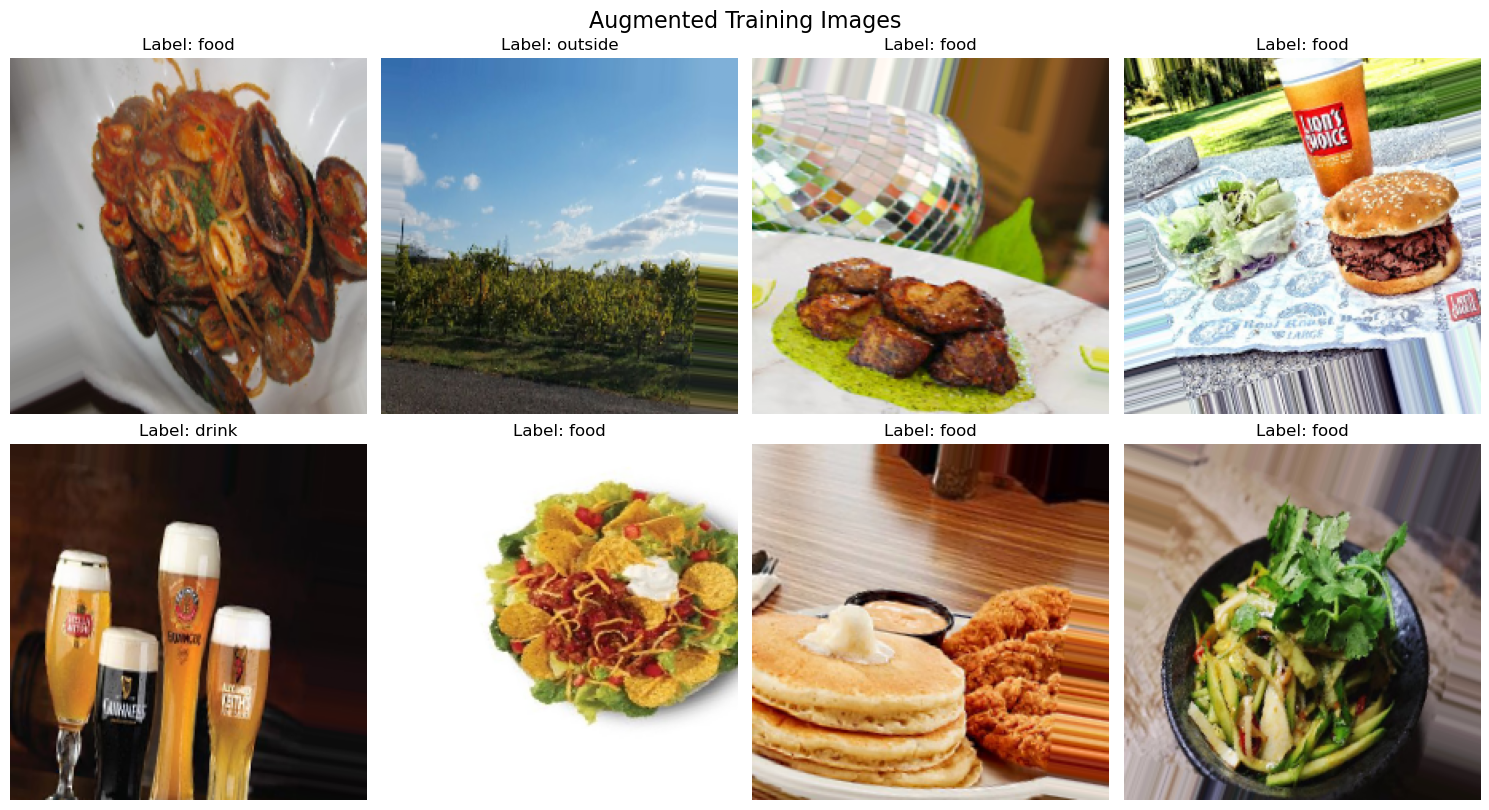

In [18]:
# 12. Visualize augmented images
print("\n12. Visualizing augmented images...")
visualize_augmentation(train_generator, label_encoder)

In [19]:
# Apply advanced preprocessing techniques
print("\n13. Applying advanced preprocessing techniques...")
sample_indices = np.random.choice(len(X_train), size=100, replace=False)
X_sample = X_train[sample_indices]

X_blur = apply_advanced_preprocessing(X_sample, apply_blur=True, apply_hist_eq=False, apply_threshold=False)
X_hist_eq = apply_advanced_preprocessing(X_sample, apply_blur=False, apply_hist_eq=True, apply_threshold=False)
X_threshold = apply_advanced_preprocessing(X_sample, apply_blur=False, apply_hist_eq=False, apply_threshold=True)
X_combined = apply_advanced_preprocessing(X_sample, apply_blur=True, apply_hist_eq=True, apply_threshold=False)

print(f"Original sample shape: {X_sample.shape}")
print(f"Processed samples created:")
print(f"  - Gaussian blur applied: {X_blur.shape}")
print(f"  - Histogram equalization applied: {X_hist_eq.shape}")
print(f"  - Intensity threshold applied: {X_threshold.shape}")
print(f"  - Combined (blur + hist_eq): {X_combined.shape}")


13. Applying advanced preprocessing techniques...
Original sample shape: (100, 224, 224, 3)
Processed samples created:
  - Gaussian blur applied: (100, 224, 224, 3)
  - Histogram equalization applied: (100, 224, 224, 3)
  - Intensity threshold applied: (100, 224, 224, 3)
  - Combined (blur + hist_eq): (100, 224, 224, 3)



14. Visualizing preprocessing effects...


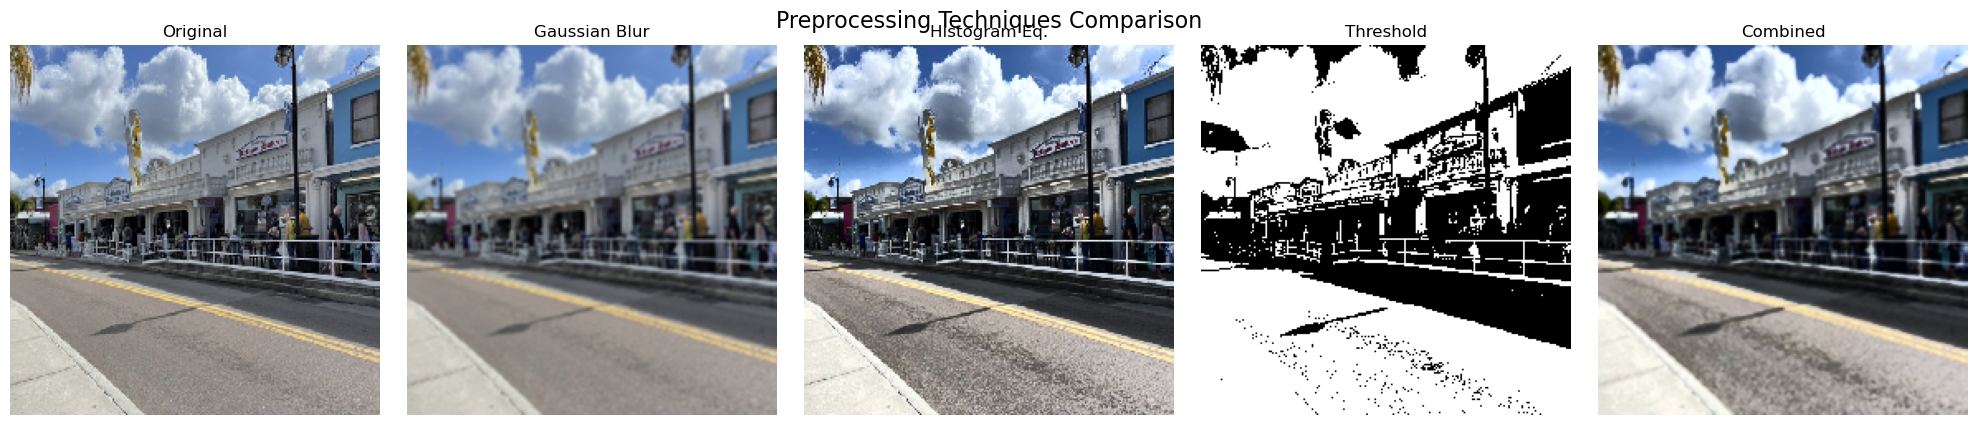

In [20]:
# Visualize preprocessing effects
print("\n14. Visualizing preprocessing effects...")
visualize_preprocessing_effects(X_sample, X_blur, X_hist_eq, X_threshold, X_combined)

### Preparing final data set 

In [21]:
# Final data preparation
print("\n15. Preparing final datasets...")
X_train_final = X_train
X_val_final = X_val
X_test_final = X_test


15. Preparing final datasets...


In [22]:
print("Final dataset shapes:")
print(f"  X_train_final: {X_train_final.shape}")
print(f"  X_val_final: {X_val_final.shape}")
print(f"  X_test_final: {X_test_final.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  business_train: {business_train.shape}")
print(f"  business_val: {business_val.shape}")
print(f"  business_test: {business_test.shape}")

Final dataset shapes:
  X_train_final: (6000, 224, 224, 3)
  X_val_final: (2000, 224, 224, 3)
  X_test_final: (2000, 224, 224, 3)
  y_train: (6000, 5)
  y_val: (2000, 5)
  y_test: (2000, 5)
  business_train: (6000, 16)
  business_val: (2000, 16)
  business_test: (2000, 16)


In [ ]:
#  Data quality checks
print("\n16. DATA QUALITY CHECKS")
check_data_quality(X_train_final, y_train, "Training Set")
check_data_quality(X_val_final, y_val, "Validation Set")  
check_data_quality(X_test_final, y_test, "Test Set")


16. DATA QUALITY CHECKS

Training Set Quality Checks:
  Shape: (6000, 224, 224, 3)
  Data type: float64
  Min value: 0.0000
  Max value: 1.0000
  Mean: 0.4475
  Std: 0.3035
  NaN values: 0
  Labels shape: (6000, 5)
  Label classes: 5

Validation Set Quality Checks:
  Shape: (2000, 224, 224, 3)
  Data type: float64
  Min value: 0.0000
  Max value: 1.0000
  Mean: 0.4519
  Std: 0.3022
  NaN values: 0
  Labels shape: (2000, 5)
  Label classes: 5

Test Set Quality Checks:
  Shape: (2000, 224, 224, 3)
  Data type: float64
  Min value: 0.0000
  Max value: 1.0000
  Mean: 0.4582
  Std: 0.3046
  NaN values: 0
  Labels shape: (2000, 5)
  Label classes: 5


### Exporting data

In [ ]:
#  Save all preprocessed data
print("\n17. Saving preprocessed data...")
save_dir = 'preprocessed_data'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save images
np.save(os.path.join(save_dir, 'X_train.npy'), X_train_final)
np.save(os.path.join(save_dir, 'X_val.npy'), X_val_final)
np.save(os.path.join(save_dir, 'X_test.npy'), X_test_final)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
np.save(os.path.join(save_dir, 'y_val.npy'), y_val)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test)

# Save business category features
np.save(os.path.join(save_dir, 'business_train.npy'), business_train)
np.save(os.path.join(save_dir, 'business_val.npy'), business_val)
np.save(os.path.join(save_dir, 'business_test.npy'), business_test)

# Save metadata
with open(os.path.join(save_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

with open(os.path.join(save_dir, 'category_feature_names.pkl'), 'wb') as f:
    pickle.dump(category_feature_names, f)


print(f"All preprocessed data saved to {save_dir}/")
print("Files saved:")
print("  Images: X_train.npy, X_val.npy, X_test.npy")
print("  Labels: y_train.npy, y_val.npy, y_test.npy") 
print("  Business Features: business_train.npy, business_val.npy, business_test.npy")
print("  Metadata: label_encoder.pkl, category_feature_names.pkl")

print(f"\nBusiness category features shape: {business_train.shape[1]}")
print(f"Category feature names: {category_feature_names}")


17. Saving preprocessed data...
All preprocessed data saved to preprocessed_data/
Files saved:
  Images: X_train.npy, X_val.npy, X_test.npy
  Labels: y_train.npy, y_val.npy, y_test.npy
  Business Features: business_train.npy, business_val.npy, business_test.npy
  Metadata: label_encoder.pkl, category_feature_names.pkl

Business category features shape: 16
Category feature names: ['num_categories', 'category_Restaurants', 'category_Food', 'category_Shopping', 'category_Home_Services', 'category_Beauty_and_Spas', 'category_Nightlife', 'category_Health_and_Medical', 'category_Local_Services', 'category_Bars', 'category_Automotive', 'category_Event_Planning_and_Services', 'category_Sandwiches', 'category_American_(Traditional)', 'category_Active_Life', 'category_Pizza']
